In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import ttest_ind
import statsmodels.stats.power as smp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [78]:
df_processes=pd.read_csv("data/processes.csv",sep='\t')
df_connections = pd.read_csv("data/connections.csv", sep='\t')
df_processes.head()


,ts,imei,mwra,p.android.chrome,p.android.externalstorage,p.android.gm,p.android.packageinstaller,p.android.settings,p.android.documentsui,p.system,...,p.inputmethod.latin,p.android.vending,p.notifier,p.katana,p.browser.provider,p.olauncher,p.process.gapps,p.google,p.android.defcontainer,p.dogalize
0,2018-05-05 10:00:00,359043379931766817,0.0,12.67131,11.51584,11.14770,16.65822,10.34567,13.85827,14.24441,...,67.41099,43.41425,76.85292,61.49504,83.84273,90.26474,64.52255,58.33299,53.62833,71.56538
1,2018-05-05 10:01:00,8630330696303481313,1.0,14.37083,10.40542,9.51907,16.41548,8.97598,13.02322,16.31514,...,63.46175,41.06191,96.50752,90.91460,28.28500,8.85422,51.89787,15.59966,73.88848,8.64346
2,2018-05-05 10:02:00,8630330696303482485,1.0,15.29793,11.57740,13.15840,11.13504,12.78871,15.33671,18.05368,...,61.37235,41.14340,14.49331,74.73880,4.18073,6.10243,44.94162,60.25186,74.62467,43.83823
3,2018-05-05 10:03:00,8630330696303481628,0.0,17.46341,11.75419,11.61736,12.61226,9.20242,11.43078,9.84154,...,43.42172,49.29721,21.64738,71.05116,62.98376,44.42369,51.61388,13.60374,19.42437,1.84968
4,2018-05-05 10:04:00,359043379931766957,0.0,10.87997,12.62410,13.19246,13.77152,15.48980,14.81432,14.67672,...,48.06657,70.43036,90.86824,42.66690,60.74888,50.69262,24.46560,70.89736,46.68829,36.31749


In [79]:
df_processes, df_processes_test = train_test_split(df_processes, test_size=0.2, random_state=42)
print(df_processes.shape,df_processes_test.shape)

(12109, 23) (3028, 23)


In [80]:
df_connections, df_connections_test = train_test_split(df_connections, test_size=0.2, random_state=42)
print(df_connections.shape,df_connections_test.shape)


(12109, 13) (3028, 13)


<Axes: >

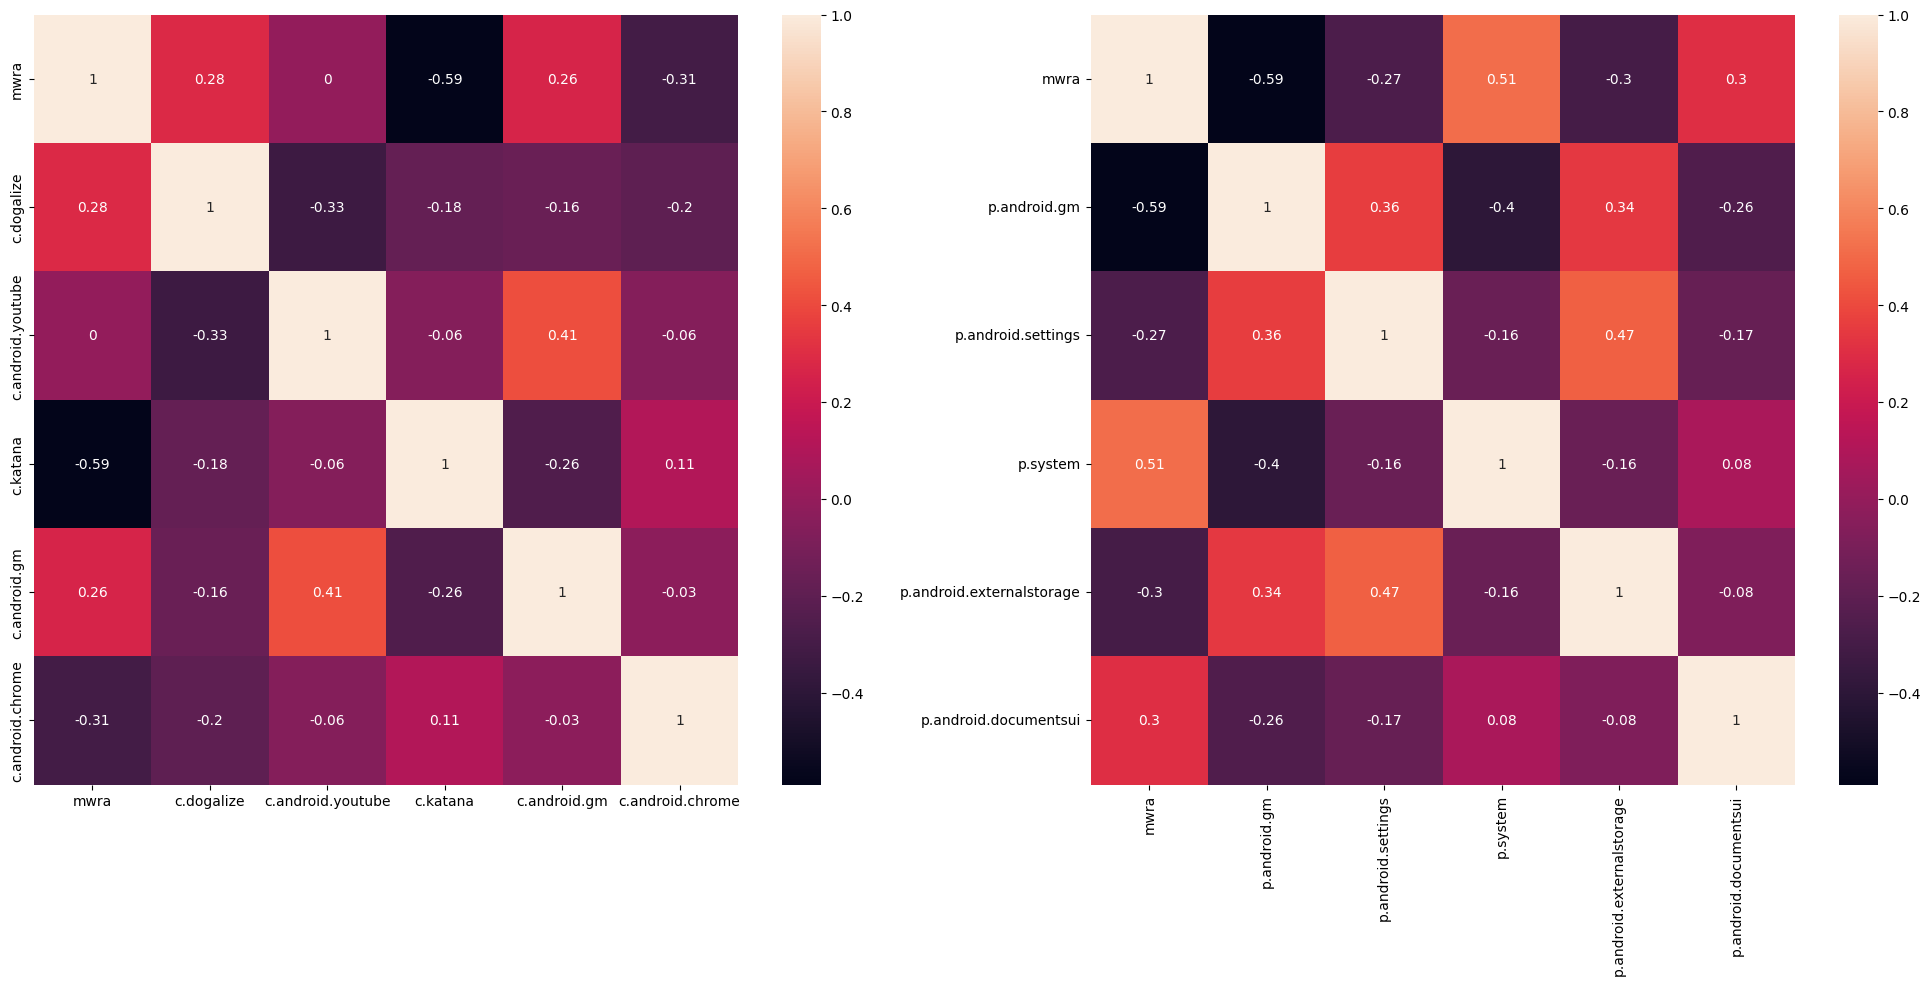

In [81]:
plt.figure(figsize=(25,10))
df_connections=df_connections[df_connections.columns[2:8]]
df_connections.drop_duplicates(inplace=True)
plt.subplot(1,2,1)
sns.heatmap(df_connections.iloc[:,:].corr().round(decimals=2),annot=True)
df_processes=df_processes[['mwra','p.android.gm','p.android.settings','p.system','p.android.externalstorage','p.android.documentsui']]

df_processes.drop_duplicates(inplace=True)
plt.subplot(1,2,2)
sns.heatmap(df_processes.iloc[:,:].corr().round(decimals=2),annot=True)


Removing outlier

In [82]:
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.222030,13.360591,13.316416,13.388931,13.906858
std,0.484119,2.420685,2.621391,2.776730,2.466921,2.468071
min,0.000000,3.492160,2.936040,2.605000,4.020180,5.614740
25%,0.000000,10.456085,11.699365,11.346090,11.804665,12.225840
50%,1.000000,11.997270,13.651800,13.339480,13.674850,14.006630
75%,1.000000,13.950395,15.199545,15.321490,15.154060,15.614400
max,1.000000,21.005110,21.756040,23.130130,23.066440,22.530620


for loop will iterate over every column and remove outlier will with help of identify outlier remove the outlier of said column by replacing it with its nearest quantile

In [83]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return (a > upper) | (a < lower)

def remove_outlier(df,column):
    outlier_mask = identify_outliers(df[column])
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    df.loc[outlier_mask, column] = np.where(
        df.loc[outlier_mask, column] < lower_bound,
        lower_bound,
        upper_bound
    )
    return df

for column in df_processes.columns:
    df_processes=remove_outlier(df_processes,column)
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.219616,13.379864,13.318666,13.404879,13.905280
std,0.484119,2.403120,2.558275,2.761312,2.410490,2.436854
min,0.000000,5.301570,6.455370,5.403180,6.781000,7.203720
25%,0.000000,10.456085,11.699365,11.346090,11.804665,12.225840
50%,1.000000,11.997270,13.651800,13.339480,13.674850,14.006630
75%,1.000000,13.950395,15.199545,15.321490,15.154060,15.614400
max,1.000000,19.187440,20.431470,21.267890,20.166420,20.681910


As can be observed , compared to the first df_connectoins.describe() the max/min values are way less extreme making it better suitable for ML

In [84]:
df_connections.describe()

,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.153374,12.752353,12.208188,12.121103,11.557645
std,0.484119,2.625899,2.685466,2.432228,2.763639,2.363564
min,0.000000,2.568060,2.890720,2.960460,2.366610,0.000000
25%,0.000000,10.297690,10.826245,10.416540,10.187660,9.917270
50%,1.000000,12.044410,12.867380,11.986450,11.955090,11.405390
75%,1.000000,13.998020,14.732575,14.021170,13.924070,13.086745
max,1.000000,21.997370,21.386740,22.398300,22.667660,20.538700


In [85]:
for column in df_connections.columns:
    df_connections=remove_outlier(df_connections,column)
df_connections.describe()

,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.152915,12.758038,12.202676,12.109756,11.550961
std,0.484119,2.604130,2.664888,2.409126,2.710240,2.306092
min,0.000000,4.789020,4.991870,5.127470,4.622840,5.217290
25%,0.000000,10.297690,10.826245,10.416540,10.187660,9.917270
50%,1.000000,12.044410,12.867380,11.986450,11.955090,11.405390
75%,1.000000,13.998020,14.732575,14.021170,13.924070,13.086745
max,1.000000,19.514050,20.556610,19.385140,19.527540,17.839290


In [86]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# we devide the tables 
std_devs = df_connections.std()
high_std_columns = std_devs[std_devs > 2.5].index
mid_std_columns = std_devs[(std_devs > 1) & (std_devs <= 2.5)].index
#apply MinMaxScaler (range 0,4 because thats also output range of RobusScaler) (first scaler)
minmax_scaler = MinMaxScaler(feature_range=(0, 4))
df_connections[mid_std_columns] = minmax_scaler.fit_transform(df_connections[mid_std_columns])

#initialize RobustScaler (second scaler)
robust_scaler = RobustScaler()
scaled_high_std = robust_scaler.fit_transform(df_connections[high_std_columns])
# remove the negative offset so we can use chi-squared test later 
offset = np.abs(scaled_high_std.min(axis=0))
df_connections[high_std_columns] = scaled_high_std + offset


array([[<Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.android.youtube'}>],
       [<Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.android.gm'}>],
       [<Axes: title={'center': 'c.android.chrome'}>, <Axes: >]],
      dtype=object)

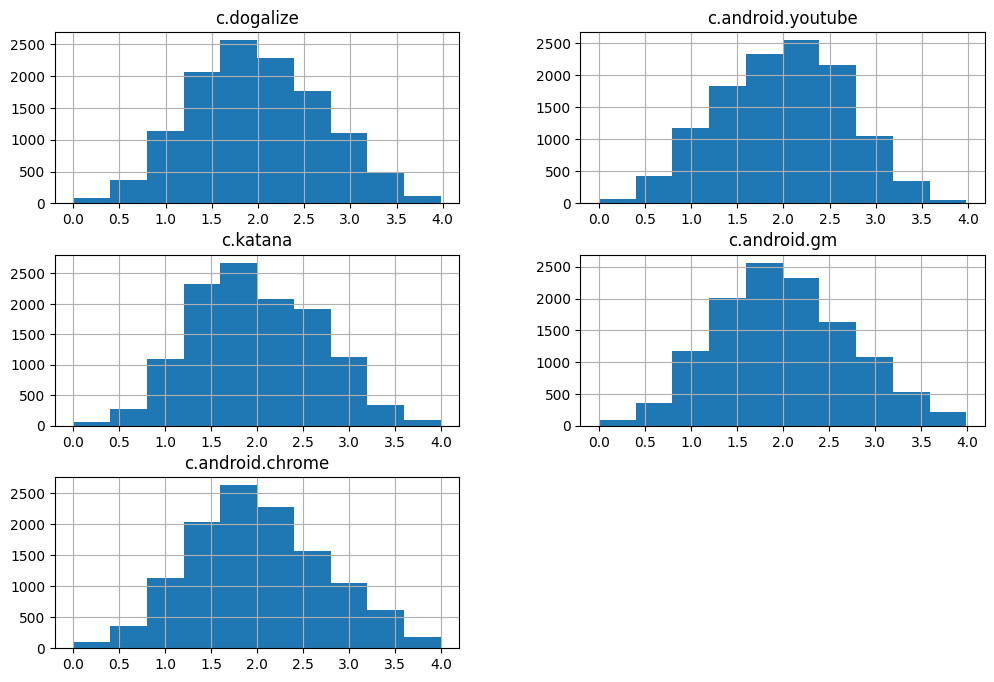

In [87]:
df_connections.hist(column=df_connections.columns[1:],figsize=(12,8))

In [88]:
df_connections.describe()

,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,1.990064,1.988098,1.984954,2.003773,2.007185
std,0.484119,0.703756,0.682197,0.675882,0.725359,0.730817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.488697,1.493569,1.483853,1.489349,1.489457
50%,1.000000,1.960741,2.016089,1.924292,1.962378,1.961052
75%,1.000000,2.488697,2.493569,2.495134,2.489349,2.493885
max,1.000000,3.979383,3.984492,4.000000,3.989043,4.000000


Displaying data for better before and after transformation

array([[<Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>, <Axes: >]],
      dtype=object)

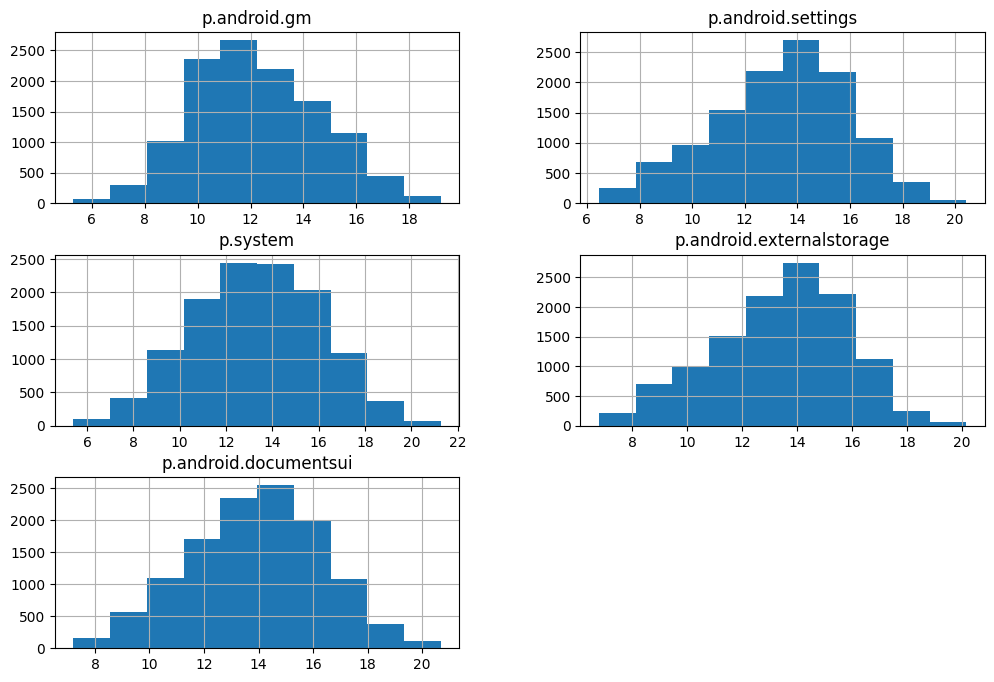

In [89]:
df_processes.hist(column=df_processes.columns[1:],figsize=(12,8))

Applying power transformer and quantile transformer . I am not really sure why i would need to do sucha thing on this data . I would understand if 4 columns were dat 0-10 and one column was 0-100 but here the data is very very similar so.


#we decided to use log transofrm (inside function transformer) and MinMaxScaler to keep the data positive because we want to use chi-squared tests later on which is not possible with lets say PowerTransformer or QuantileTransformer .


In [90]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer# type: ignore
std_devs = df_processes.std()
high_std_columns = std_devs[std_devs > 2.5].index
mid_std_columns = std_devs[(std_devs > 1) & (std_devs <= 2.5)].index
power_transformer = PowerTransformer(method='box-cox')
quantile_transformer = QuantileTransformer(output_distribution='normal')
df_processes[mid_std_columns] = power_transformer.fit_transform(df_processes[mid_std_columns])
df_processes[high_std_columns] = quantile_transformer.fit_transform(df_processes[high_std_columns])

array([[<Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>, <Axes: >]],
      dtype=object)

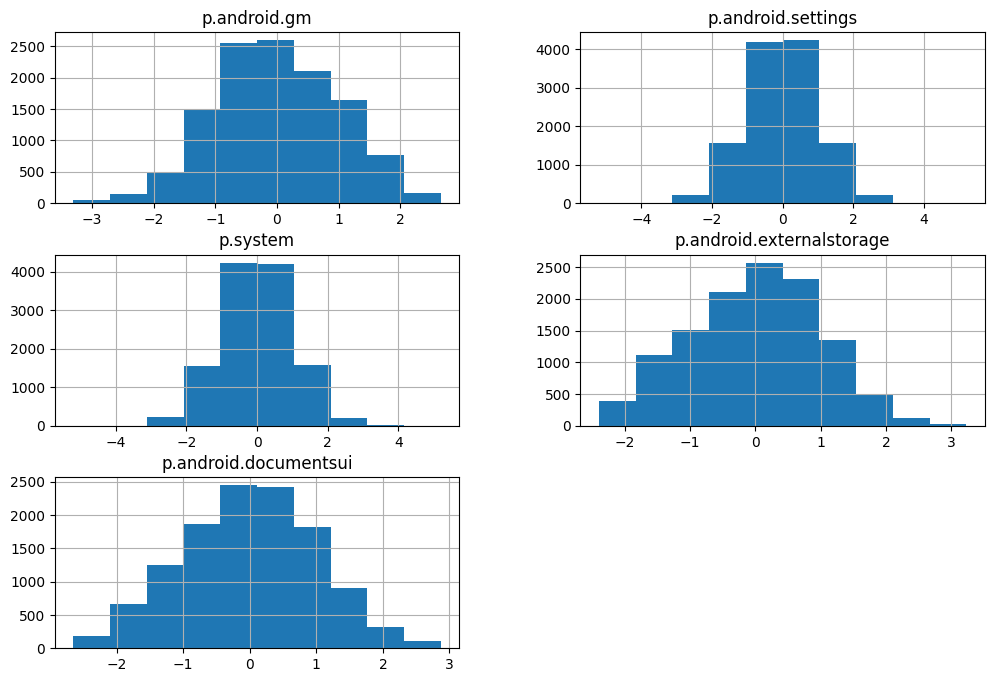

In [91]:
df_processes.hist(column=df_processes.columns[1:],figsize=(12,8))

In [92]:
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,11995.000000,1.199500e+04,11995.000000,11995.000000,1.199500e+04,1.199500e+04
mean,0.625094,-2.209524e-16,0.002579,0.001846,1.747479e-16,1.753403e-16
std,0.484119,1.000042e+00,1.000397,0.999100,1.000042e+00,1.000042e+00
min,0.000000,-3.304212e+00,-5.199338,-5.199338,-2.392881e+00,-2.650189e+00
25%,0.000000,-7.136242e-01,-0.670120,-0.673839,-7.094645e-01,-6.985143e-01
50%,1.000000,-5.152714e-02,0.002757,-0.002416,5.667969e-02,2.778642e-02
75%,1.000000,7.388760e-01,0.676627,0.684047,7.116266e-01,6.961151e-01
max,1.000000,2.657914e+00,5.199338,5.199338,3.231288e+00,2.869803e+00


In [93]:
cn_train_non = df_connections.drop(columns=['mwra'])
cn_train_mwra = df_connections['mwra']

mi_scores = mutual_info_classif(cn_train_non, cn_train_mwra)
mi_scores_series = pd.Series(mi_scores, index=cn_train_non.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n", mi_scores_series)

Mutual Information Scores:
 c.katana             0.217985
c.android.chrome     0.081021
c.dogalize           0.053667
c.android.gm         0.045142
c.android.youtube    0.001209
dtype: float64


In [94]:
pr_train_non = df_processes.drop(columns=['mwra'])
pr_train_mwra = df_processes['mwra']

mi_scores = mutual_info_classif(pr_train_non, pr_train_mwra)
mi_scores_series = pd.Series(mi_scores, index=pr_train_non.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n", mi_scores_series)

Mutual Information Scores:
 p.android.gm                 0.219967
p.system                     0.154962
p.android.documentsui        0.051734
p.android.settings           0.051109
p.android.externalstorage    0.048213
dtype: float64


In [95]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(score_func=f_regression, k=3)
Chi_connections = selector.fit_transform(cn_train_non, cn_train_mwra)

feature_scores = selector.scores_
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [cn_train_non.columns[i] for i in selected_feature_indices]

print("Selected Features:", selected_feature_names)
print("Scores of Selected Features:", feature_scores[selected_feature_indices])

Selected Features: ['c.dogalize', 'c.katana', 'c.android.chrome']
Scores of Selected Features: [1014.49990893 6487.4390717  1342.86428168]


In [96]:
selector = SelectKBest(score_func=f_regression, k=3)
Chi_processes = selector.fit_transform(pr_train_non, pr_train_mwra)

feature_scores = selector.scores_
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [pr_train_non.columns[i] for i in selected_feature_indices]

print("Selected Features:", selected_feature_names)
print("Scores of Selected Features:", feature_scores[selected_feature_indices])

Selected Features: ['p.android.gm', 'p.system', 'p.android.documentsui']
Scores of Selected Features: [6270.36657002 4073.71148973 1195.74331749]


In [97]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

X = cn_train_non
y = cn_train_mwra

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

print("Selected features (True indicates selected):", selector.support_)
print("Feature ranking (1 indicates selected features):", selector.ranking_)

Selected features (True indicates selected): [ True  True  True  True  True]
Feature ranking (1 indicates selected features): [1 1 1 1 1]


In [98]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

X = pr_train_non
y = pr_train_mwra

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

print("Selected features (True indicates selected):", selector.support_)
print("Feature ranking (1 indicates selected features):", selector.ranking_)

Selected features (True indicates selected): [ True  True  True  True  True]
Feature ranking (1 indicates selected features): [1 1 1 1 1]
